In [171]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load data

In [172]:
cleansed=load_amihud_markets_price()

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [108]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

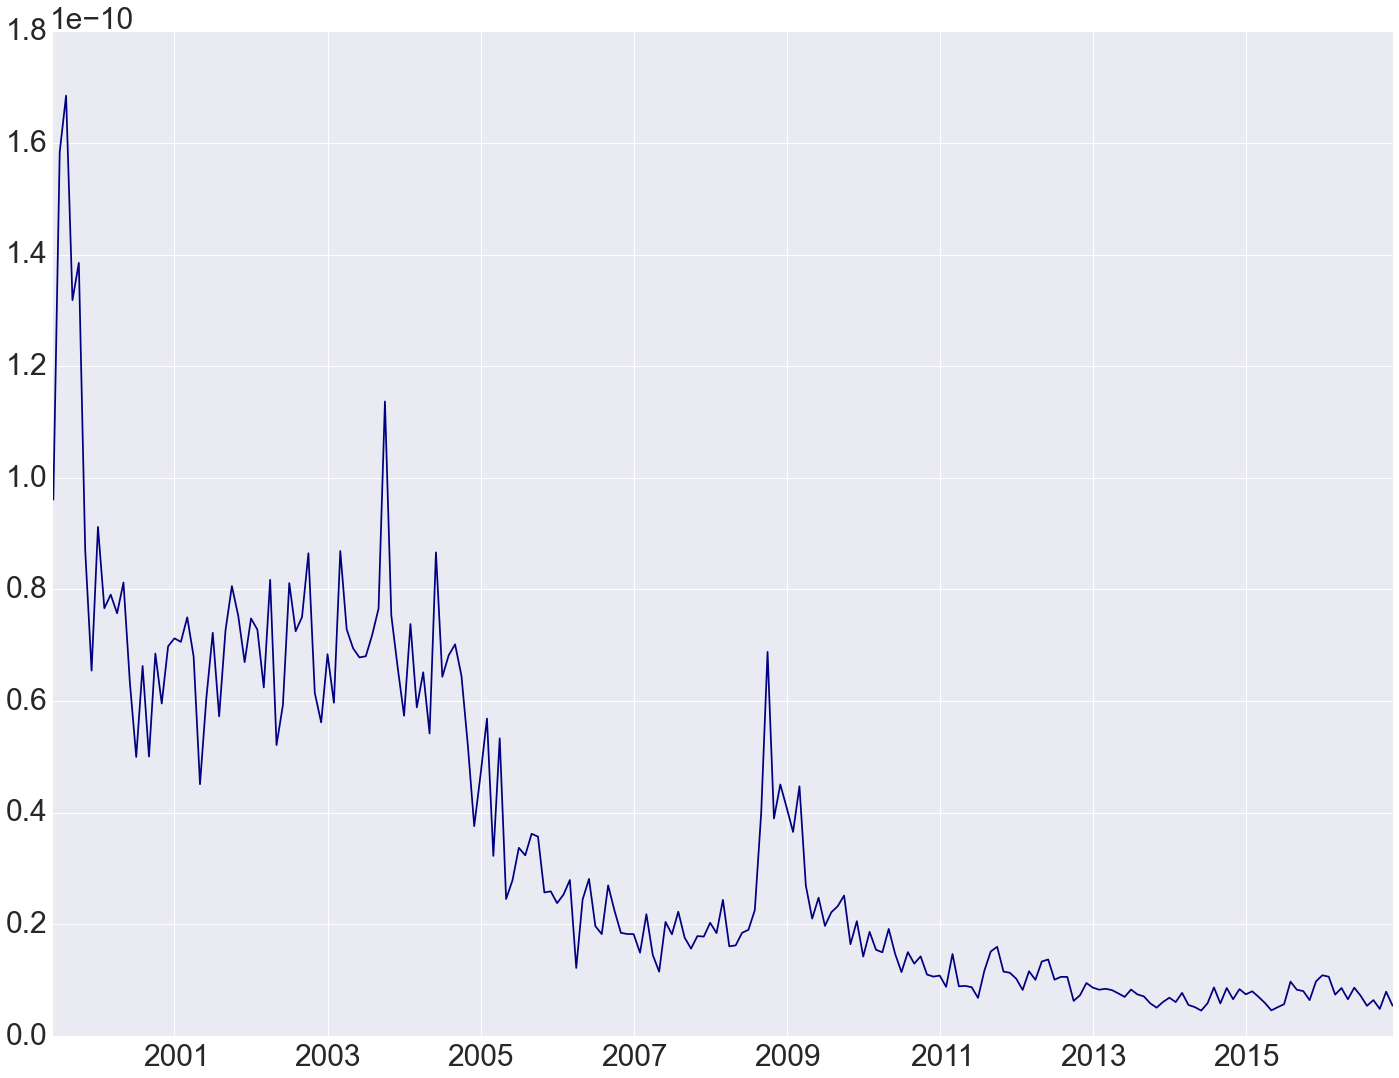

In [109]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


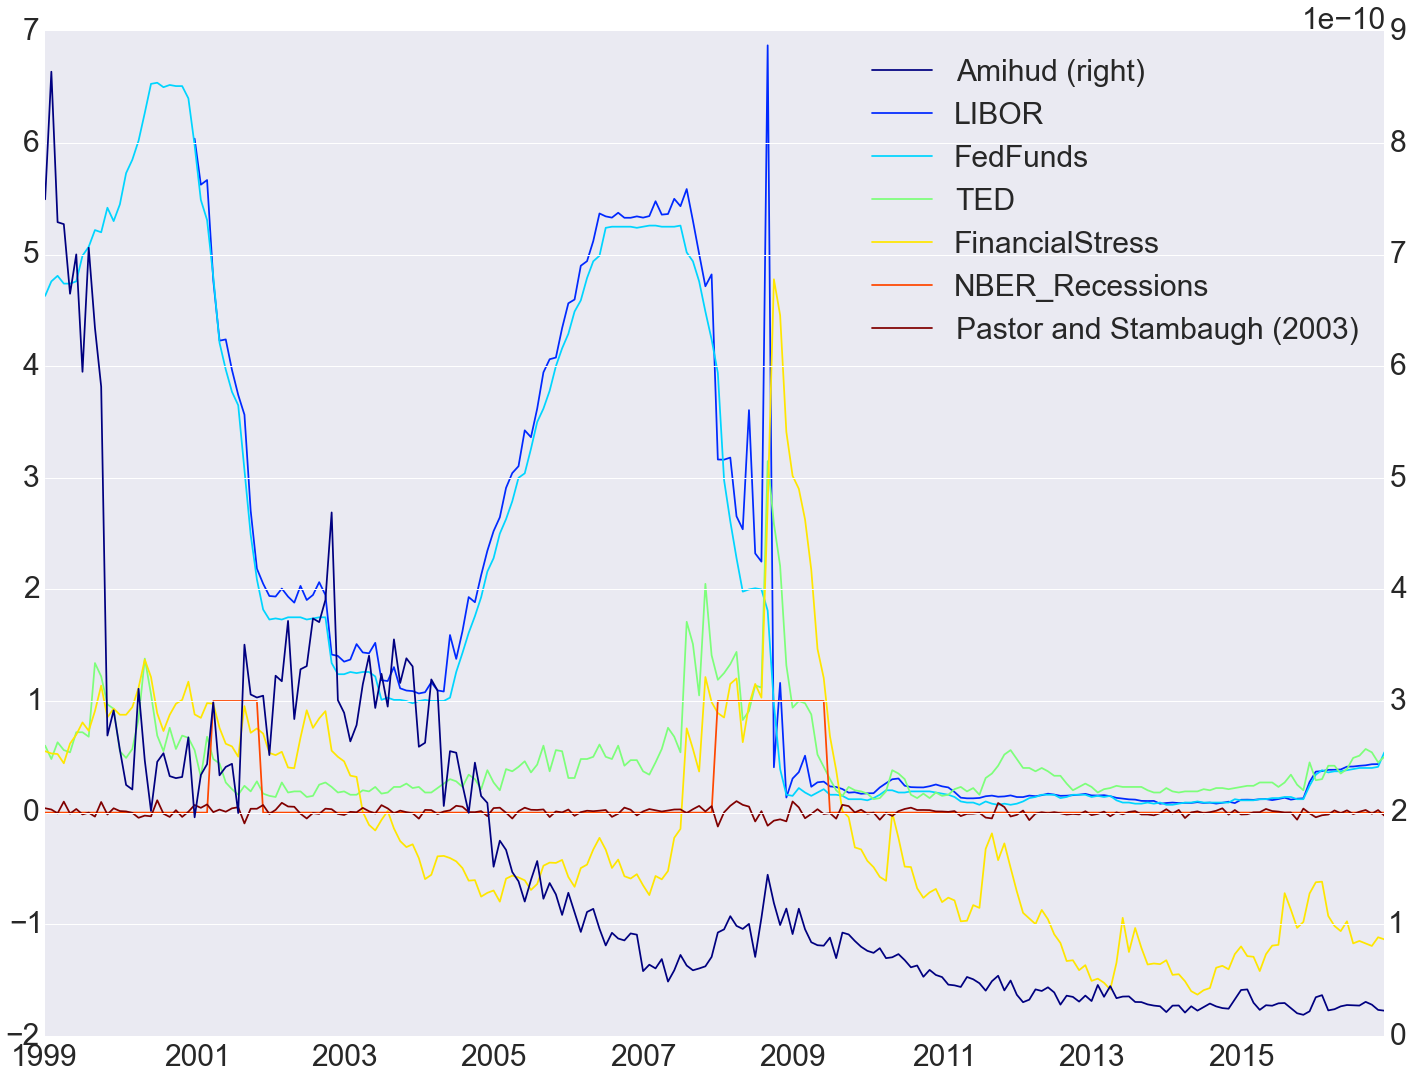

In [175]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [111]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


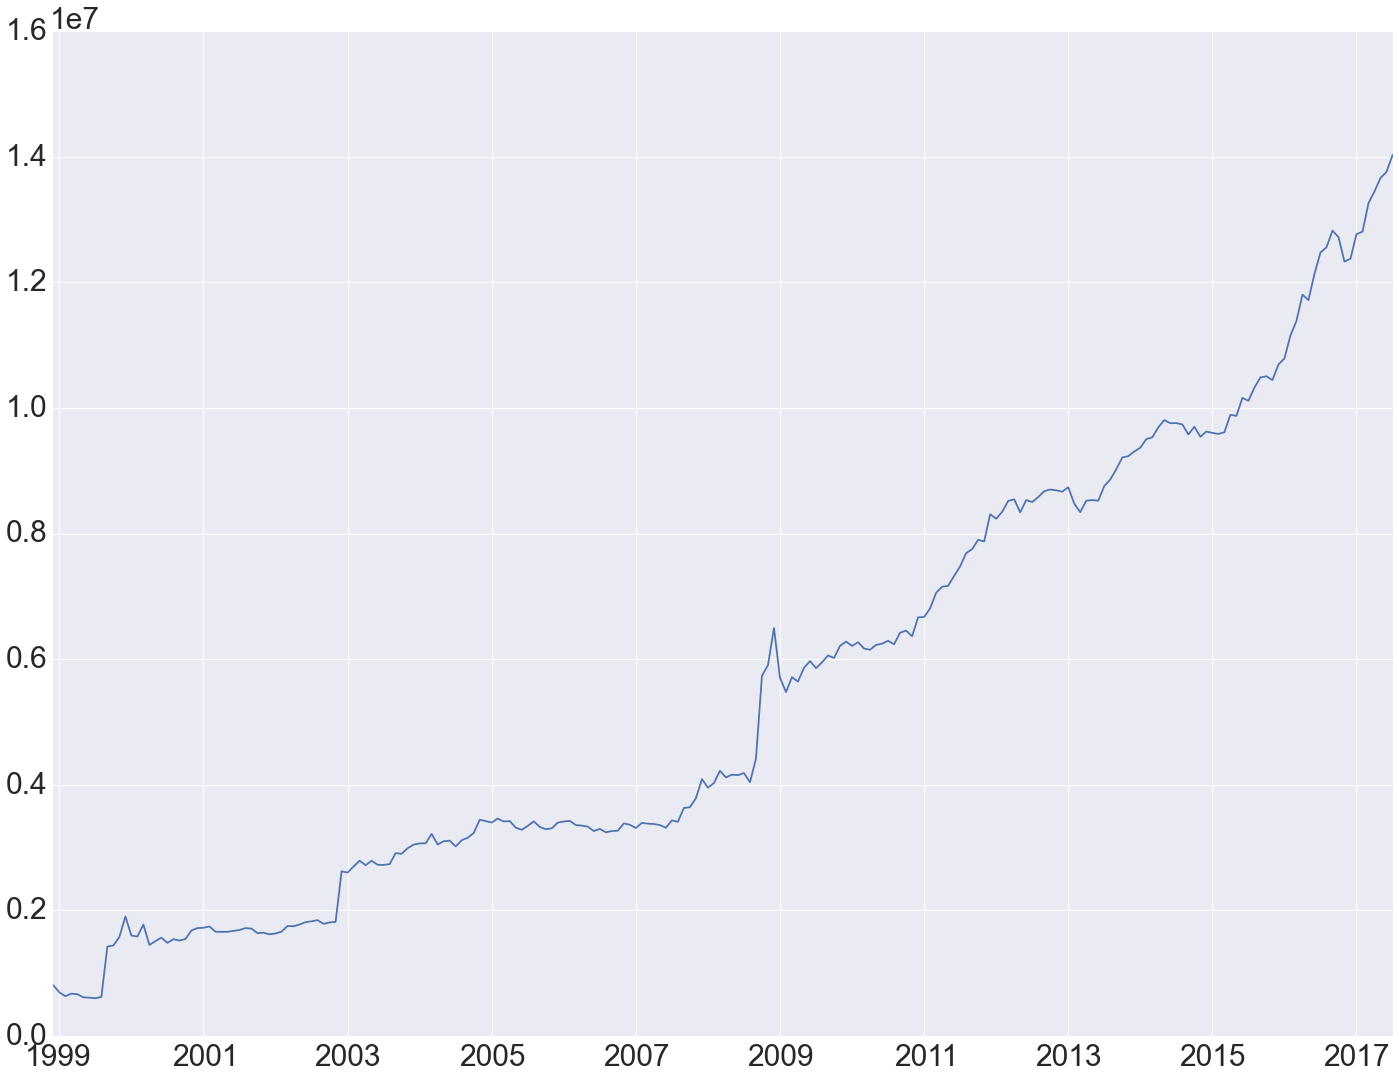

In [112]:
(central_banks_asset/fx).dropna(how='all').sum(axis=1).plot()

In [113]:
factors['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [114]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [115]:
factors.columns

Index([u'Amihud', u'LIBOR', u'FedFunds', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)',
       u'Central Bank Assets'],
      dtype='object')

In [116]:

col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']

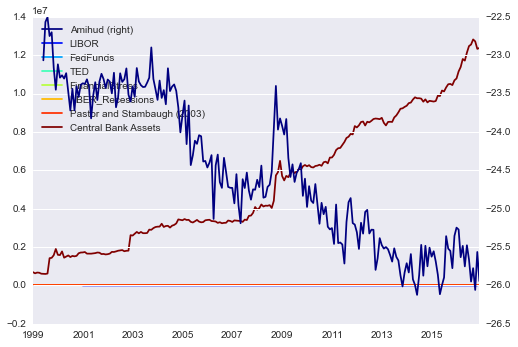

In [130]:
factors.plot(colormap='jet',secondary_y='Amihud')

In [117]:
res = VAR.VAR(endog=factors[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Aug, 2017
Time:                     20:19:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.9290
Nobs:                     190.000    HQIC:                   17.7257
Log likelihood:          -2729.18    FPE:                4.34554e+07
AIC:                      17.5872    Det(Omega_mle):     3.91669e+07
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -5.766879         1.156132           -4.988           0.000
L1.Amihud                      0.748354         0.050753           14.745           0.000
L1.LIBOR               

In [118]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [119]:
df

,Values,Tstat
const,-5.766879e+00,-4.988081
L1.Amihud,7.483542e-01,14.744966
L1.LIBOR,-2.544373e-02,-1.714463
L1.FinancialStress,2.926340e-02,1.378090
L1.Central Bank Assets,-6.808947e-08,-4.062528


In [120]:
x=res.params.Amihud

In [121]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [131]:
print y.round(2).to_latex()

\begin{tabular}{lr}
\toprule
{} &  Results \\
\midrule
const                  &    -5.77 \\
L1.Amihud              &     0.75 \\
L1.LIBOR               &    -0.03 \\
L1.FinancialStress     &     0.03 \\
L1.Central Bank Assets &    -0.00 \\
const                  &    -4.99 \\
L1.Amihud              &    14.74 \\
L1.LIBOR               &    -1.71 \\
L1.FinancialStress     &     1.38 \\
L1.Central Bank Assets &    -4.06 \\
\bottomrule
\end{tabular}



In [132]:
res = VAR.VAR(endog=factors[col].dropna()).fit(2)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Aug, 2017
Time:                     20:28:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.2610
Nobs:                     189.000    HQIC:                   16.8936
Log likelihood:          -2609.53    FPE:                1.69159e+07
AIC:                      16.6435    Det(Omega_mle):     1.40437e+07
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -4.134838         1.164035           -3.552           0.000
L1.Amihud                      0.454322         0.074464            6.101           0.000
L1.LIBOR               

In [159]:
res = VAR.VAR(endog=factors[col].dropna()).fit(5)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Aug, 2017
Time:                     20:50:10
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.8386
Nobs:                     186.000    HQIC:                   16.9721
Log likelihood:          -2495.20    FPE:                1.30676e+07
AIC:                      16.3818    Det(Omega_mle):     8.51858e+06
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -2.071334         1.292859           -1.602           0.111
L1.Amihud                      0.317999         0.083812            3.794           0.000
L1.LIBOR               

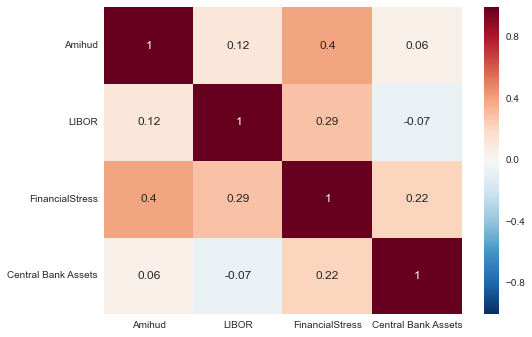

In [160]:
sns.heatmap(pd.DataFrame(res.resid_corr,index=col,columns=col),annot=True)

In [161]:
print pd.DataFrame(res.resid_corr,index=col,columns=col).round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Amihud &  LIBOR &  FinancialStress &  Central Bank Assets \\
\midrule
Amihud              &    1.00 &   0.12 &             0.40 &                 0.06 \\
LIBOR               &    0.12 &   1.00 &             0.29 &                -0.07 \\
FinancialStress     &    0.40 &   0.29 &             1.00 &                 0.22 \\
Central Bank Assets &    0.06 &  -0.07 &             0.22 &                 1.00 \\
\bottomrule
\end{tabular}



In [134]:
model = VAR.VAR(endog=factors[col].dropna())

In [135]:
model.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         28.41        28.48    2.185e+12        28.44
1         17.77        18.13    5.239e+07        17.92
2         16.71       17.35*    1.800e+07        16.97
3         16.52        17.45    1.494e+07       16.90*
4         16.43        17.65    1.370e+07        16.93
5        16.39*        17.90   1.319e+07*        17.00
6         16.40        18.19    1.336e+07        17.13
7         16.48        18.57    1.460e+07        17.33
8         16.55        18.91    1.562e+07        17.51
9         16.49        19.14    1.483e+07        17.56
10        16.50        19.44    1.514e+07        17.69
11        16.45        19.68    1.456e+07        17.76
12        16.46        19.98    1.499e+07        17.89
13        16.47        20.27    1.528e+07        18.01
14        16.48        20.57    1.582e+07        18.14
* Minimum


{'aic': 5, 'bic': 2, 'fpe': 5, 'hqic': 3}

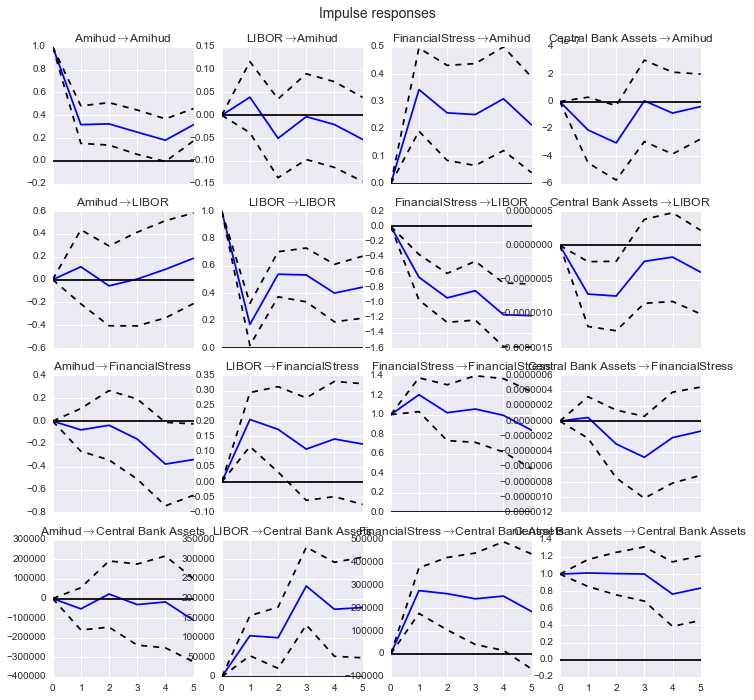

In [137]:
resaic = model.fit(maxlags=5,ic='aic')
irf=resaic.irf(5)
sns.set(font_scale=1)
irf.plot()